# Summary

## BERT + CNN

**BERT**

BERT

**CNN**

CNN

# Code

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install -q transformers==4.37.2
!pip install imbalanced-learn
# !pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 16.9 MB/s eta 0:00:00


In [2]:
#@title Imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


## Load Data

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

# Data Path
train_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/train_data_binary.csv'
test_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/test_data_binary.csv'

# Load Raw Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

Mounted at /content/gdrive


## Data Overview

In [4]:
train_data.head()

,Comment,Labels
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
train_data.shape

(159571, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

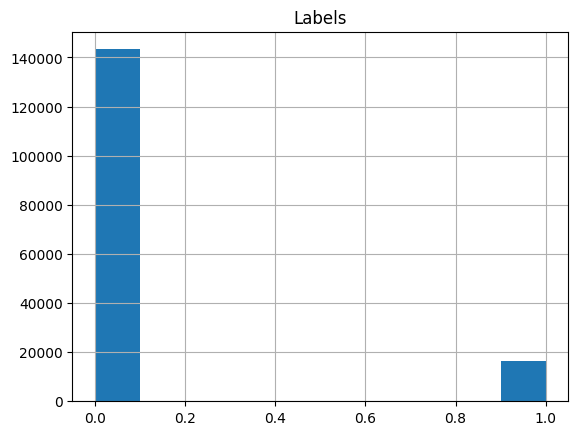

In [6]:
train_data.hist()

In [7]:
train_data['Labels'].value_counts()

Labels
0    143346
1     16225
Name: count, dtype: int64

In [8]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", train_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
train_subset, _ = train_test_split(train_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
train_subset.reset_index(drop=True, inplace=True)
train_under = train_subset
print("After random undersampling", train_under['Labels'].value_counts())

Before random undersampling Labels
0    143346
1     16225
Name: count, dtype: int64
After random undersampling Labels
0    57280
1     6548
Name: count, dtype: int64


In [9]:
#random undersampling on majority class
#check number of values per class
print("Before random undersampling:", train_data['Labels'].value_counts())

# define undersampling strategy
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=1234)

# Perform undersampling on the training data
train_comments_resampled, train_labels_resampled = undersampler.fit_resample(train_data[['Comment']], train_data['Labels'])

# Convert the resampled data back to a DataFrame
train_resampled = pd.DataFrame(train_comments_resampled, columns=['Comment'])
train_resampled['Labels'] = train_labels_resampled

#check number of values per class
print("After random undersampling:", train_resampled['Labels'].value_counts())

Before random undersampling: Labels
0    143346
1     16225
Name: count, dtype: int64
After random undersampling: Labels
0    16225
1    16225
Name: count, dtype: int64


In [10]:
test_data.head()

,Comment,Labels
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \n\n It says it right there that it IS a typ...",0
4,""" \n\n == Before adding a new product to the l...",0


In [11]:
test_data.shape

(63978, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

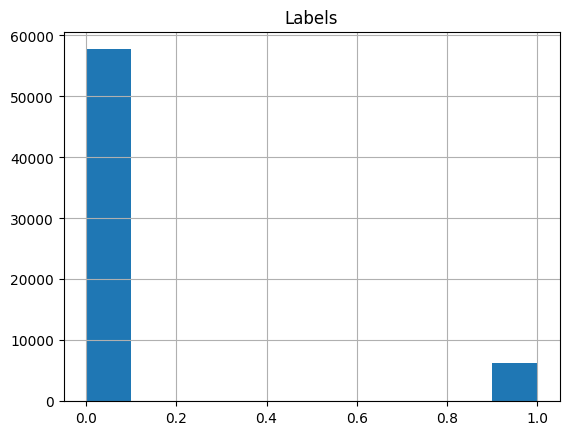

In [12]:
test_data.hist()

In [13]:
test_data['Labels'].value_counts()

Labels
0    57735
1     6243
Name: count, dtype: int64

In [14]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", test_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
test_subset, _ = train_test_split(test_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
test_subset.reset_index(drop=True, inplace=True)
test_under = test_subset
print("After random undersampling", test_under['Labels'].value_counts())

Before random undersampling Labels
0    57735
1     6243
Name: count, dtype: int64
After random undersampling Labels
0    23130
1     2461
Name: count, dtype: int64


In [15]:
#random undersampling on majority class
#check number of values per class
print("Before random undersampling:", test_data['Labels'].value_counts())

# define undersampling strategy
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=1234)

# Perform undersampling on the training data
test_comments_resampled, test_labels_resampled = undersampler.fit_resample(test_data[['Comment']], test_data['Labels'])

# Convert the resampled data back to a DataFrame
test_resampled = pd.DataFrame(test_comments_resampled, columns=['Comment'])
test_resampled['Labels'] = test_labels_resampled

#check number of values per class
print("After random undersampling:", test_resampled['Labels'].value_counts())

Before random undersampling: Labels
0    57735
1     6243
Name: count, dtype: int64
After random undersampling: Labels
0    6243
1    6243
Name: count, dtype: int64


## Create train_texts, train_labels, valid_texts, valid_labels, test_texts, and test_labels

In [16]:
# Splitting the data into train and validation sets
train_data, val_data = train_test_split(train_under, test_size=0.2, random_state=42)

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [17]:
train_texts = train_data['Comment']
train_texts

0        Christianity is only mentioned three times in ...
1        My Thoughts \n\nYou're a fucking piece of shit...
2        "\nIf you want to customize your userpage, you...
3                          Exactly how are my edits so bad
4        "\n If you'd actually take the time to look ar...
                               ...                        
51057    "\n\nThats not very nice for the people of San...
51058    November 2007 (UTC)\n\nI've been thinking of t...
51059    Track map? \n\nCan a track map be made by jdjo...
51060     "\nOK, but are they ""most"" ? Rajyaमहाराष्ट्र "
51061    William Cooley GA Nomination \n\nHi Horologium...
Name: Comment, Length: 51062, dtype: object

In [18]:
train_labels = train_data['Labels']
train_labels

0        0
1        1
2        0
3        0
4        0
        ..
51057    0
51058    0
51059    0
51060    0
51061    0
Name: Labels, Length: 51062, dtype: int64

In [19]:
valid_texts = val_data['Comment']
valid_texts

0        "\n\nFlyer is right, reliable sources are bein...
1        "\n\n Mistake in Map \n\nHello All,\n\nThe map...
2        "\nHi Rjensen. Thanks for getting back to me. ...
3        I have made no changes to the template, only a...
4        Further update: I've now discovered that the C...
                               ...                        
12761    "\n\nAward ceremony dates\nFound a source for ...
12762    Bio means life or living!! \n\nCell isn't mech...
12763    CJ DUB Continues To Insult Wiki Editors & User...
12764    "\nIf only you had followed your own advice a ...
12765    I think we should see what the RFC determines ...
Name: Comment, Length: 12766, dtype: object

In [20]:
valid_labels = val_data['Labels']
valid_labels

0        0
1        0
2        0
3        0
4        0
        ..
12761    0
12762    0
12763    0
12764    0
12765    0
Name: Labels, Length: 12766, dtype: int64

In [21]:
test_texts = test_under['Comment']
test_texts

0        Clayton High School \n Hello, I recently remov...
1        " \n\n  Please do not vandalize pages, as you ...
2                                  ::Learn to spell, yank.
3        " \n : As a member of the community, I have re...
4        == Eschew Obfuscation == \n\n If you're intere...
                               ...                        
25586    :Are you proposing something here or opining o...
25587    :I don't think there is sufficient reason to e...
25588    " \n\n == The harm of articles == \n\n Accordi...
25589    " \n\n == Local names 2nd time == \n\n  \n\n Y...
25590                fuckin super gay ass bitch headAlamos
Name: Comment, Length: 25591, dtype: object

In [22]:
test_labels = test_under['Labels']
test_labels

0        0
1        0
2        0
3        0
4        0
        ..
25586    0
25587    0
25588    0
25589    0
25590    1
Name: Labels, Length: 25591, dtype: int64

In [23]:
# maximum comment length for train_texts
train_texts_max_length = max(train_texts.str.len())
train_texts_max_length

5000

In [24]:
# maximum comment length for train_texts
test_texts_max_length = max(test_texts.str.len())
test_texts_max_length

5000


## BERT-based Classification Models

In [25]:
#make it easier to use a variety of BERT subword models
# model_checkpoint = 'bert-base-cased'
model_checkpoint ='bert-base-multilingual-cased'

In [26]:
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [27]:
# token_lengths = [len(bert_tokenizer.encode(text, add_special_tokens=True)) for text in train_texts]

# max_token_length = max(token_lengths)

# max_token_length

In [28]:
max_length = 512

In [29]:
# tokenize the dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [30]:
train_encodings

{'input_ids': <tf.Tensor: shape=(51062, 512), dtype=int32, numpy=
array([[  101, 41953, 10124, ...,     0,     0,     0],
       [  101, 11590, 57246, ...,     0,     0,     0],
       [  101,   107, 14535, ...,     0,     0,     0],
       ...,
       [  101, 26403, 14876, ...,     0,     0,     0],
       [  101,   107, 47168, ...,     0,     0,     0],
       [  101, 10694, 40248, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(51062, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(51062, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [31]:
valid_encodings

{'input_ids': <tf.Tensor: shape=(12766, 512), dtype=int32, numpy=
array([[  101,   107, 34476, ...,     0,     0,     0],
       [  101,   107, 99946, ...,     0,     0,     0],
       [  101,   107, 20065, ...,     0,     0,     0],
       ...,
       [  101, 80622,   141, ...,     0,     0,     0],
       [  101,   107, 14535, ...,     0,     0,     0],
       [  101,   146, 27874, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(12766, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(12766, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [32]:
test_encodings

{'input_ids': <tf.Tensor: shape=(25591, 512), dtype=int32, numpy=
array([[  101, 43687, 11956, ...,     0,     0,     0],
       [  101,   107, 47464, ...,     0,     0,     0],
       [  101,   131,   131, ...,     0,     0,     0],
       ...,
       [  101,   107,   134, ...,     0,     0,     0],
       [  101,   107,   134, ...,     0,     0,     0],
       [  101, 11005, 18768, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(25591, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(25591, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [33]:
train_encodings.input_ids.shape

TensorShape([51062, 512])

In [34]:
valid_encodings.input_ids.shape

TensorShape([12766, 512])

In [35]:
test_encodings.input_ids.shape

TensorShape([25591, 512])

### CLS-Token-based Classification

In [36]:
def create_bert_cls_binary_model(checkpoint = model_checkpoint,
                                 max_sequence_length = max_length,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00001):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """

    # Fresh instance of the bert_model
    bert_base_model = TFBertModel.from_pretrained(checkpoint)
    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [37]:
bert_cls_binary_model = create_bert_cls_binary_model(checkpoint=model_checkpoint)

bert_cls_binary_model_history = bert_cls_binary_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
    train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=8,
    epochs=2
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2
6383/6383 [==============================] - 6643s 1s/step - loss: 0.1255 - accuracy: 0.9519 - val_loss: 0.1007 - val_accuracy: 0.9619
Epoch 2/2
6383/6383 [==============================] - 6595s 1s/step - loss: 0.0806 - accuracy: 0.9685 - val_loss: 0.0970 - val_accuracy: 0.9635


In [38]:
bert_cls_binary_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

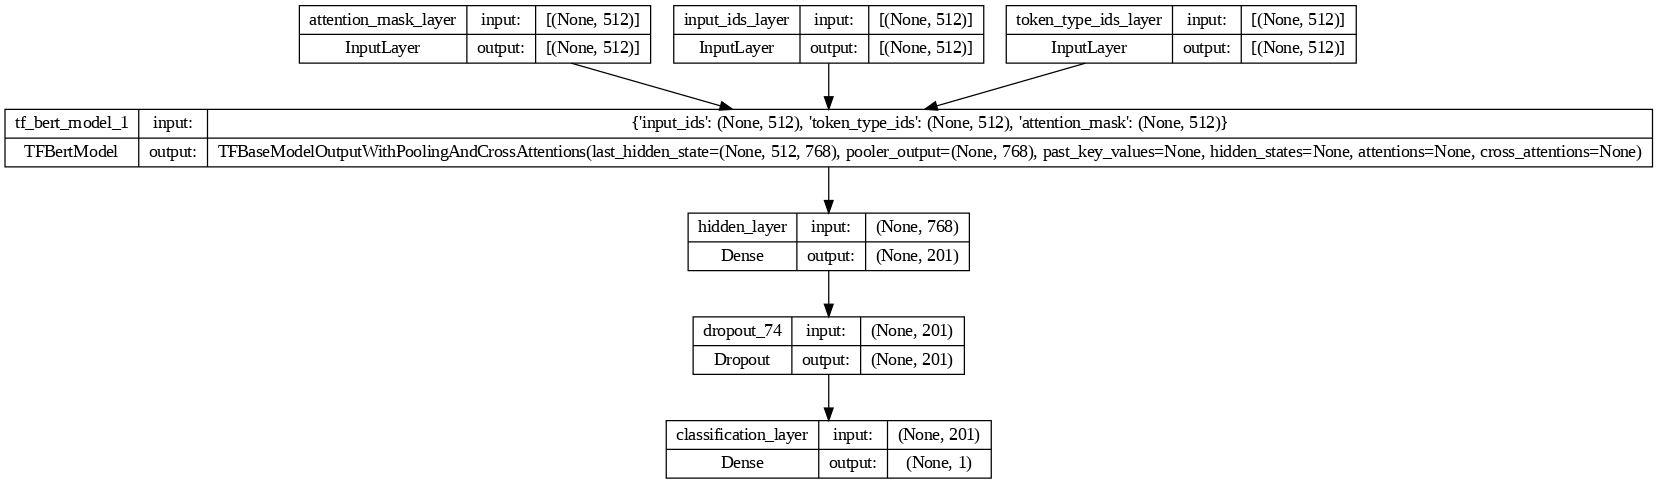

In [39]:
keras.utils.plot_model(bert_cls_binary_model, show_shapes=True, dpi=90)

800/800 [==============================] - 1058s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     23130
           1       0.51      0.89      0.65      2461

    accuracy                           0.91     25591
   macro avg       0.75      0.90      0.80     25591
weighted avg       0.94      0.91      0.92     25591

ROC AUC Score: 0.9621984145932051


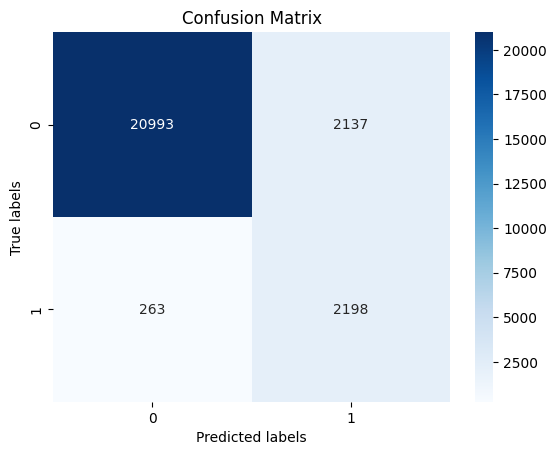

In [40]:
# Make predictions
predictions = bert_cls_binary_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

###Adding a CNN on top of BERT

BERT provides a sequence of contextualized token embeddings as its main output, and a CNN takes a sequence of vectors as input.

In [41]:
def create_bert_cnn_model(bert_cnn_model,
                          max_sequence_length=max_length,
                          num_filters = [131, 127, 51, 23, 17],
                          kernel_sizes = [2, 3, 4, 5, 7],
                          dropout = 0.3,
                          hidden_size = 275,
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    bert_cnn_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_cnn_model(bert_inputs)

    last_hidden_state = bert_out[0]

    # CNN layers
    cnn_input = last_hidden_state

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_input)
        conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = tf.keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    # Dropout and Dense layers
    hidden = tf.keras.layers.Dropout(dropout)(conv_output)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    return classification_model

In [42]:
#bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

bert_cnn_model = create_bert_cnn_model(bert_model)


bert_cnn_model_history = bert_cnn_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
    train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=8,
    epochs=2
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


6383/6383 [==============================] - 6838s 1s/step - loss: 0.1275 - accuracy: 0.9520 - val_loss: 0.1084 - val_accuracy: 0.9640
Epoch 2/2
6383/6383 [==============================] - 6840s 1s/step - loss: 0.0818 - accuracy: 0.9685 - val_loss: 0.1063 - val_accuracy: 0.9596


In [43]:
bert_cnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                    

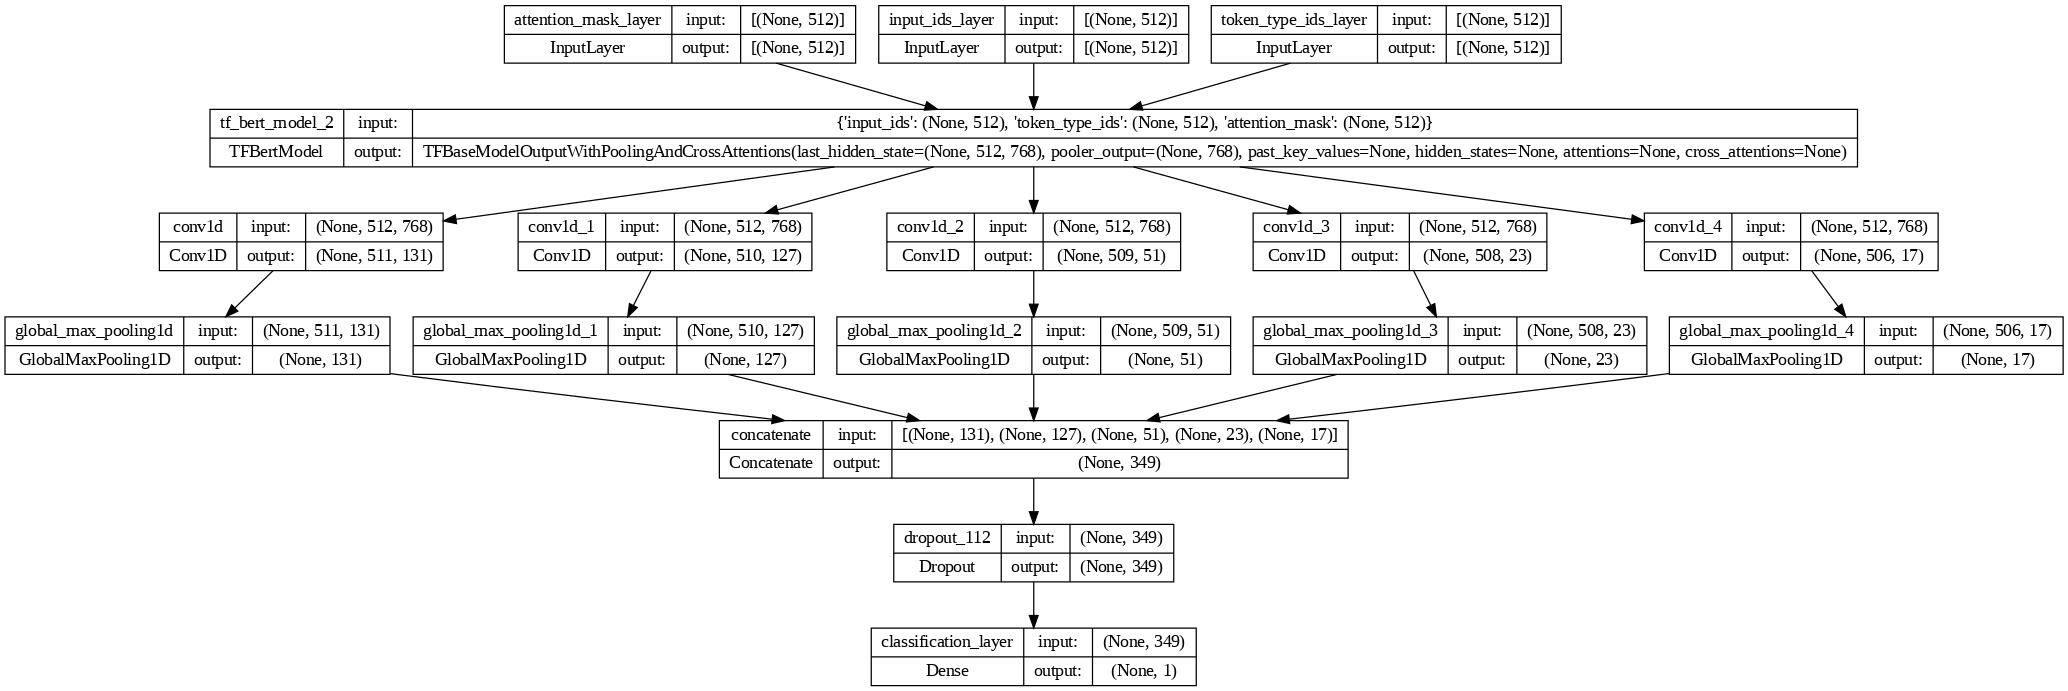

In [44]:
keras.utils.plot_model(bert_cnn_model, show_shapes=True, dpi=90)

800/800 [==============================] - 1072s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     23130
           1       0.46      0.93      0.61      2461

    accuracy                           0.89     25591
   macro avg       0.72      0.91      0.77     25591
weighted avg       0.94      0.89      0.90     25591

ROC AUC Score: 0.965704330399015


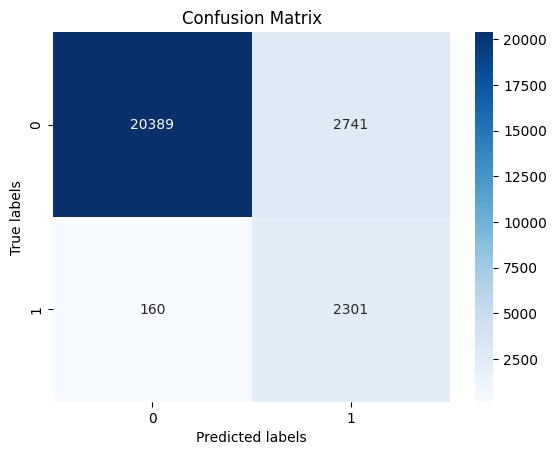

In [45]:
# Make predictions
predictions = bert_cnn_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

###Adding a RNN on top of BERT

BERT provides a sequence of contextualized token embeddings as its main output, and a RNN takes a sequence of vectors as input.

In [46]:
def create_bert_rnn_model(bert_rnn_model,
                          max_sequence_length=max_length,
                          rnn_dim=100,
                          dense_layer_dims=[100],
                          dropout_rate = 0.5,
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply RNN layers  to the BERT output
    """

    bert_rnn_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_rnn_model(bert_inputs)

    last_hidden_state = bert_out[0]

    # RNN layers
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (last_hidden_state)
    last_hidden_output = rnn_output

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(last_hidden_output)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    return classification_model

In [47]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

bert_rnn_model = create_bert_rnn_model(bert_model)


bert_rnn_model_history = bert_rnn_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
    train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=8,
    epochs=2
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


6383/6383 [==============================] - 7051s 1s/step - loss: 0.1356 - accuracy: 0.9514 - val_loss: 0.1096 - val_accuracy: 0.9559
Epoch 2/2
6383/6383 [==============================] - 7013s 1s/step - loss: 0.0885 - accuracy: 0.9668 - val_loss: 0.1059 - val_accuracy: 0.9559


In [49]:
bert_rnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                    

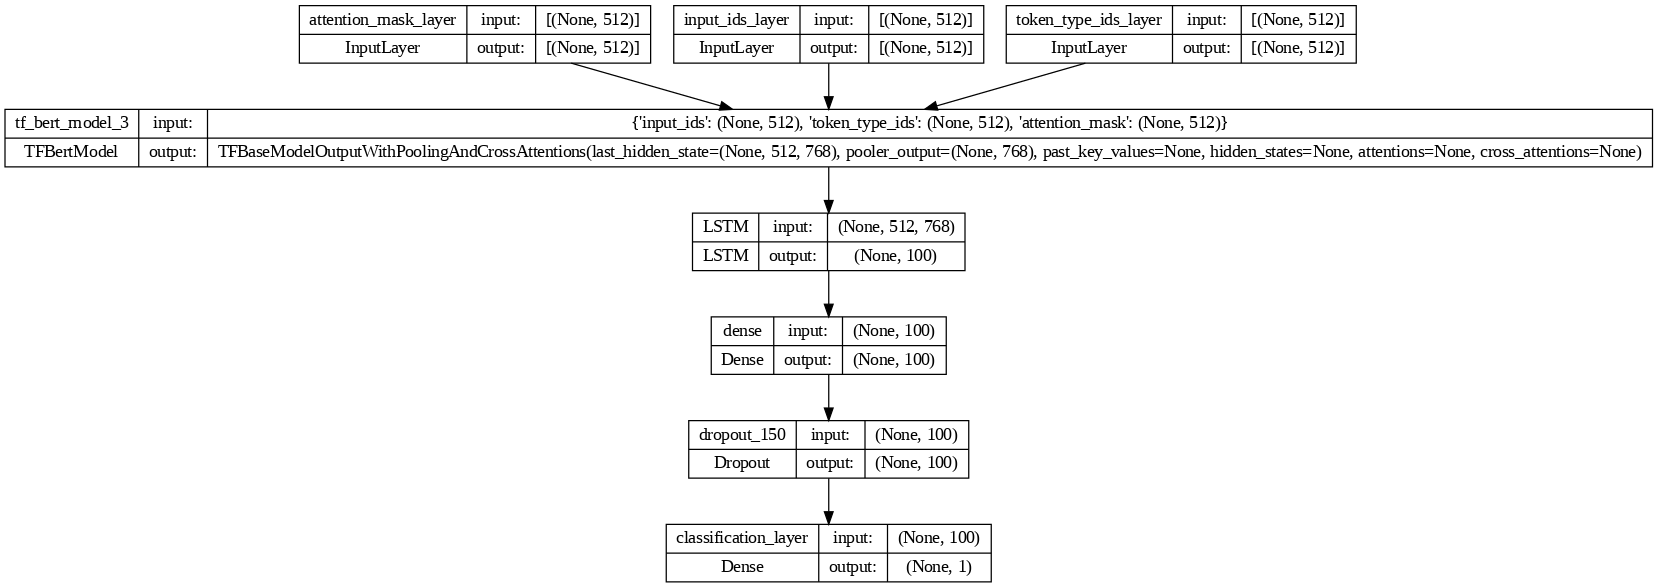

In [50]:
keras.utils.plot_model(bert_rnn_model, show_shapes=True, dpi=90)

800/800 [==============================] - 1061s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     23130
           1       0.45      0.92      0.61      2461

    accuracy                           0.89     25591
   macro avg       0.72      0.90      0.77     25591
weighted avg       0.94      0.89      0.90     25591

ROC AUC Score: 0.9618031784379336


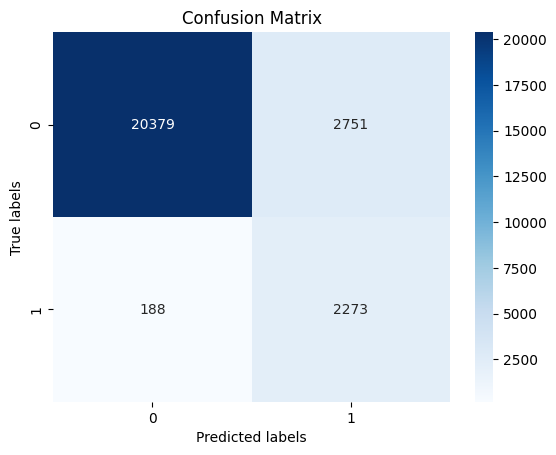

In [51]:
# Make predictions
predictions = bert_rnn_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

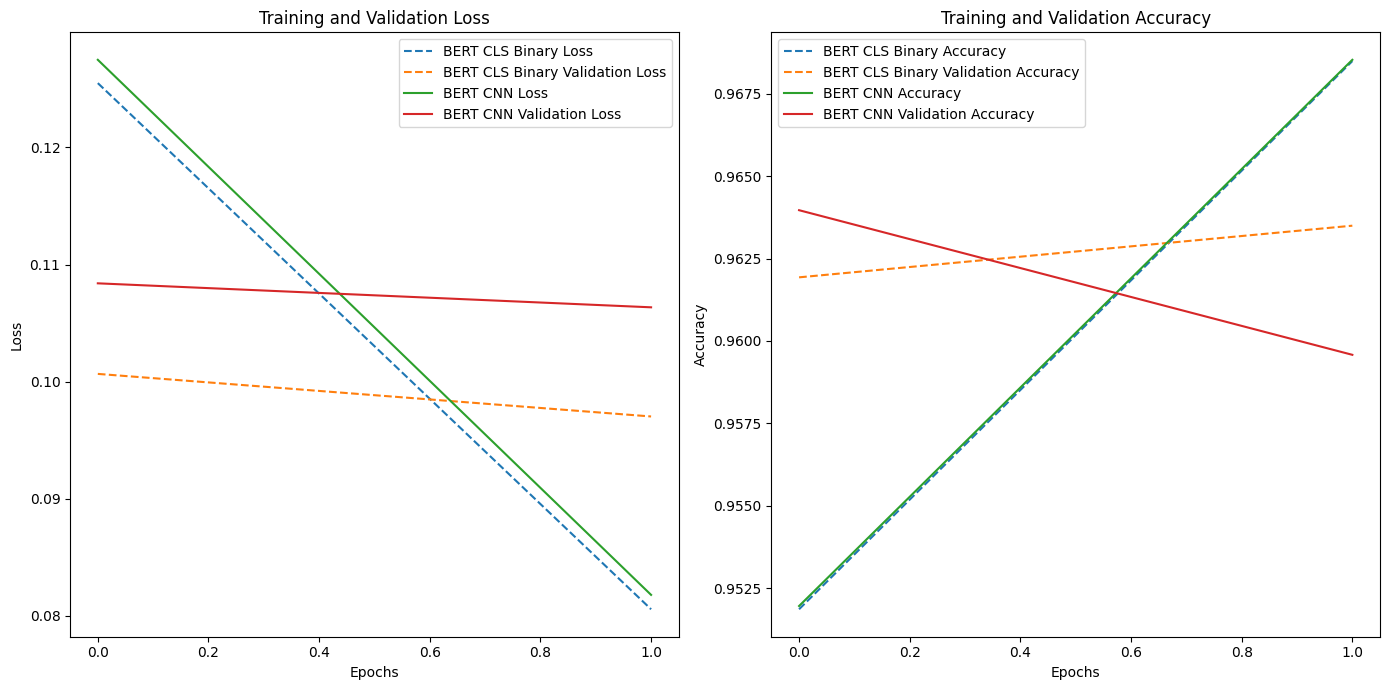

In [48]:
# Extracting loss and accuracy from the second model history
bert_cls_binary_loss = bert_cls_binary_model_history.history['loss']
bert_cls_binary_val_loss = bert_cls_binary_model_history.history['val_loss']
bert_cls_binary_accuracy = bert_cls_binary_model_history.history['accuracy']
bert_cls_binary_val_accuracy = bert_cls_binary_model_history.history['val_accuracy']

bert_cnn_loss = bert_cnn_model_history.history['loss']
bert_cnn_val_loss = bert_cnn_model_history.history['val_loss']
bert_cnn_accuracy = bert_cnn_model_history.history['accuracy']
bert_cnn_val_accuracy = bert_cnn_model_history.history['val_accuracy']

bert_rnn_loss = bert_rnn_model_history.history['loss']
bert_rnn_val_loss = bert_rnn_model_history.history['val_loss']
bert_rnn_accuracy = bert_rnn_model_history.history['accuracy']
bert_rnn_val_accuracy = bert_rnn_model_history.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(bert_cls_binary_loss, label='BERT CLS Binary Loss', linestyle="--")
plt.plot(bert_cls_binary_val_loss, label='BERT CLS Binary Validation Loss', linestyle="--")
plt.plot(bert_cnn_loss, label='BERT CNN Loss')
plt.plot(bert_cnn_val_loss, label='BERT CNN Validation Loss')
plt.plot(bert_rnn_loss, label='BERT RNN Loss')
plt.plot(bert_rnn_val_loss, label='BERT RNN Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(bert_cls_binary_accuracy, label='BERT CLS Binary Accuracy', linestyle="--")
plt.plot(bert_cls_binary_val_accuracy, label='BERT CLS Binary Validation Accuracy', linestyle="--")
plt.plot(bert_cnn_accuracy, label='BERT CNN Accuracy')
plt.plot(bert_cnn_val_accuracy, label='BERT CNN Validation Accuracy')
plt.plot(bert_rnn_accuracy, label='BERT RNN Accuracy')
plt.plot(bert_rnn_val_accuracy, label='BERT RNN Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()